# Temporal Resolution and Aggregation Analysis

This notebook investigates how different temporal aggregation strategies affect feature and class separability using the AFX library.

## Objectives

1. **Temporal Resolution Impact**: Understand how temporal resolution affects feature discriminability
2. **Aggregation Strategies**: Compare frame-wise, sliding-window, and global aggregation approaches
3. **Optimal Strategies**: Identify optimal temporal aggregation for lightweight models
4. **Temporal Variability**: Quantify temporal variability across different classes

## Aggregation Strategies Compared

- **Frame-wise** (no aggregation): Preserve full temporal resolution
- **Sliding Window** (mean/std over fixed-length hop): Intermediate temporal resolution
- **Global Aggregation** (mean/std/skew/kurt over entire clip): Single value per clip

## Prerequisites

- ESC-50 dataset downloaded and extracted
- AFX library installed


## Setup and Imports

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# AFX imports
from AFX.io.io import load_audio
from AFX.utils.config_loader import load_config
from AFX.extract_all import extract_all_features
from AFX.utils.aggregator import aggregate_features, sliding_window_aggregation
from AFX.utils.visualization import plot_feature_distribution

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore', category=UserWarning)

print("🔧 Setup complete")

🔧 Setup complete


## Dataset Setup and Configuration

In [2]:
# ESC-50 Dataset paths
ESC_50_PATHS = [
    os.environ.get('ESC_50_dataset'),  # Environment variable
    '../data/ESC-50-master',           # Common relative path
    '/tmp/ESC-50-master',              # Downloaded path
    './data/ESC-50-master'             # Current directory
]

dataset_path = None
for path in ESC_50_PATHS:
    if path and os.path.exists(path):
        dataset_path = path
        break

if dataset_path is None:
    print("❌ ESC-50 dataset not found. Please ensure it's downloaded and in one of these locations:")
    for path in ESC_50_PATHS[1:]:
        print(f"   - {path}")
    print("   - Or set the ESC_50_dataset environment variable")
    sys.exit(1)

print(f"📂 Using dataset: {dataset_path}")

# Load AFX config
config_path = os.path.join(os.path.dirname(os.path.abspath('')), 'AFX', 'config.json')
if not os.path.exists(config_path):
    config_path = '../AFX/config.json'
if not os.path.exists(config_path):
    config_path = './config.json'

config = load_config(config_path)

# We want to preserve temporal structure for analysis
config['preserve_shape'] = True
config['return_metadata'] = False

print("🔧 AFX Configuration:")
print(f"Sample rate: {config['sample_rate']} Hz")
print(f"Available features: {list(config['features'].keys())}")
print(f"Feature preservation: {config.get('preserve_shape', False)}")

# Focus on MFCC and Mel spectrogram for this analysis
FOCUS_FEATURES = ['mfcc', 'melspectrogram']
print(f"\n🎯 Focusing on features: {FOCUS_FEATURES}")

📂 Using dataset: D:\datasets\ESC-50-master
🔧 AFX Configuration:
Sample rate: 22050 Hz
Available features: ['zcr', 'variance', 'kurtosis', 'autocorr_variance', 'mobility', 'complexity', 'sample_entropy', 'energy_ratio', 'short_time_energy', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_contrast', 'spectral_entropy', 'spectral_flatness', 'spectral_flux', 'spectral_skewness', 'spectral_slope', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta_delta', 'chroma_stft', 'chroma_cqt', 'cqt', 'pitch', 'thd', 'hnr', 'gfcc']
Feature preservation: True

🎯 Focusing on features: ['mfcc', 'melspectrogram']


## Data Loading and Feature Extraction

In [3]:
# Load ESC-50 metadata
meta_file = os.path.join(dataset_path, 'meta', 'esc50.csv')
audio_dir = os.path.join(dataset_path, 'audio')

if not os.path.exists(meta_file):
    raise FileNotFoundError(f"Metadata file not found: {meta_file}")

meta_df = pd.read_csv(meta_file)
print(f"📊 Loaded metadata for {len(meta_df)} audio files")
print(f"📈 Number of classes: {meta_df['category'].nunique()}")
print(f"📈 Files per class: {len(meta_df) // meta_df['category'].nunique()}")

# For temporal analysis, we'll use a subset for faster processing
# Select 5 classes with good variability for detailed analysis
selected_categories = ['dog', 'rain', 'crackling_fire', 'helicopter', 'church_bells']
analysis_df = meta_df[meta_df['category'].isin(selected_categories)].copy()

print(f"\n🎯 Selected {len(selected_categories)} categories for detailed analysis:")
for cat in selected_categories:
    count = len(analysis_df[analysis_df['category'] == cat])
    print(f"  - {cat}: {count} files")

# Extract features for analysis subset
print("\n🔄 Extracting features...")
features_data = []
labels = []
filenames = []

for idx, row in analysis_df.iterrows():
    audio_path = os.path.join(audio_dir, row['filename'])
    if not os.path.exists(audio_path):
        print(f"⚠️  Audio file not found: {audio_path}")
        continue
    
    try:
        # Load audio
        signal, sr = load_audio(audio_path, sr=config['sample_rate'])
        
        # Extract all features (preserved temporal structure)
        features = extract_all_features(signal, sr, config)
        
        # Filter to focus features only
        focus_features = {k: v for k, v in features.items() if k in FOCUS_FEATURES}
        
        features_data.append(focus_features)
        labels.append(row['category'])
        filenames.append(row['filename'])
        
    except Exception as e:
        print(f"⚠️  Error processing {row['filename']}: {e}")
        continue

print(f"✅ Successfully extracted features from {len(features_data)} files")

# Display feature shapes
if features_data:
    print("\n📐 Feature shapes (before aggregation):")
    sample_features = features_data[0]
    for feat_name, feat_data in sample_features.items():
        print(f"  {feat_name}: {feat_data.shape}")

📊 Loaded metadata for 2000 audio files
📈 Number of classes: 50
📈 Files per class: 40

🎯 Selected 5 categories for detailed analysis:
  - dog: 40 files
  - rain: 40 files
  - crackling_fire: 40 files
  - helicopter: 40 files
  - church_bells: 40 files

🔄 Extracting features...
✅ Successfully extracted features from 200 files

📐 Feature shapes (before aggregation):
  melspectrogram: (128, 216)
  mfcc: (13, 212)


## Temporal Aggregation Strategies

In [4]:
def apply_aggregation_strategy(features_list, labels, strategy_name, **kwargs):
    """
    Apply aggregation strategy to a list of feature dictionaries.
    """
    aggregated_data = []
    
    for features in features_list:
        if strategy_name == 'frame_wise':
            # Frame-wise: No aggregation, just flatten temporal dimension
            flat_features = {}
            for k, v in features.items():
                if v.ndim > 1:
                    # Flatten all dimensions after the first
                    flat_features[k] = v.flatten()
                else:
                    flat_features[k] = v
            aggregated_data.append(flat_features)
            
        elif strategy_name == 'sliding_window':
            # Sliding window aggregation
            window_size = kwargs.get('window_size', 10)
            hop_length = kwargs.get('hop_length', 5)
            agg_method = kwargs.get('agg_method', 'mean')
            
            windowed = sliding_window_aggregation(features, window_size, hop_length, agg_method)
            # Flatten the results
            flat_windowed = {k: v.flatten() for k, v in windowed.items()}
            aggregated_data.append(flat_windowed)
            
        elif strategy_name == 'global':
            # Global aggregation: statistical summary over entire clip
            agg_method = kwargs.get('agg_method', 'advanced_summary')
            global_agg = aggregate_features(features, method=agg_method, flatten=True)
            aggregated_data.append(global_agg)
            
        else:
            raise ValueError(f"Unknown aggregation strategy: {strategy_name}")
    
    return aggregated_data

# Define aggregation strategies to compare
aggregation_strategies = {
    'frame_wise': {
        'name': 'Frame-wise (No Aggregation)',
        'description': 'Preserve full temporal resolution',
        'kwargs': {}
    },
    'sliding_window_small': {
        'name': 'Sliding Window (Small)',
        'description': 'Window size: 5 frames, hop: 2 frames',
        'kwargs': {'window_size': 5, 'hop_length': 2, 'agg_method': 'mean'}
    },
    'sliding_window_large': {
        'name': 'Sliding Window (Large)',
        'description': 'Window size: 20 frames, hop: 10 frames',
        'kwargs': {'window_size': 20, 'hop_length': 10, 'agg_method': 'mean'}
    },
    'global': {
        'name': 'Global Aggregation',
        'description': 'Mean, std, skew, kurtosis over entire clip',
        'kwargs': {'agg_method': 'advanced_summary'}
    }
}

# Apply all aggregation strategies
print("🔄 Applying aggregation strategies...")
aggregated_results = {}

for strategy_key, strategy_info in aggregation_strategies.items():
    print(f"  📊 {strategy_info['name']}...")
    
    if strategy_key.startswith('sliding_window'):
        agg_data = apply_aggregation_strategy(
            features_data, labels, 'sliding_window', **strategy_info['kwargs']
        )
    elif strategy_key == 'global':
        agg_data = apply_aggregation_strategy(
            features_data, labels, 'global', **strategy_info['kwargs']
        )
    else:  # frame_wise
        agg_data = apply_aggregation_strategy(
            features_data, labels, 'frame_wise', **strategy_info['kwargs']
        )
    
    aggregated_results[strategy_key] = {
        'data': agg_data,
        'labels': labels,
        'info': strategy_info
    }
    
    # Display dimensionality info
    if agg_data:
        sample_dims = {}
        for feat_name in FOCUS_FEATURES:
            if feat_name in agg_data[0]:
                sample_dims[feat_name] = agg_data[0][feat_name].shape[0]
        print(f"    📐 Feature dimensions: {sample_dims}")

print("✅ Aggregation strategies applied")

🔄 Applying aggregation strategies...
  📊 Frame-wise (No Aggregation)...
    📐 Feature dimensions: {'mfcc': 2756, 'melspectrogram': 27648}
  📊 Sliding Window (Small)...
    📐 Feature dimensions: {'mfcc': 1352, 'melspectrogram': 13568}
  📊 Sliding Window (Large)...
    📐 Feature dimensions: {'mfcc': 260, 'melspectrogram': 2560}
  📊 Global Aggregation...
    📐 Feature dimensions: {}
✅ Aggregation strategies applied


## Temporal Variability Analysis

📊 Analyzing temporal variability across classes...

🎯 MFCC Temporal Variability:
  helicopter     : μ=8.7984, σ=8.7411
  crackling_fire : μ=13.6248, σ=7.9962
  church_bells   : μ=11.3366, σ=4.0128
  rain           : μ=5.3228, σ=1.2816
  dog            : μ=30.3113, σ=9.2508

🎯 MELSPECTROGRAM Temporal Variability:
  helicopter     : μ=4.9503, σ=2.4333
  crackling_fire : μ=1.6707, σ=6.1094
  church_bells   : μ=8.5165, σ=9.1375
  rain           : μ=1.2657, σ=1.2567
  dog            : μ=11.9500, σ=12.8539


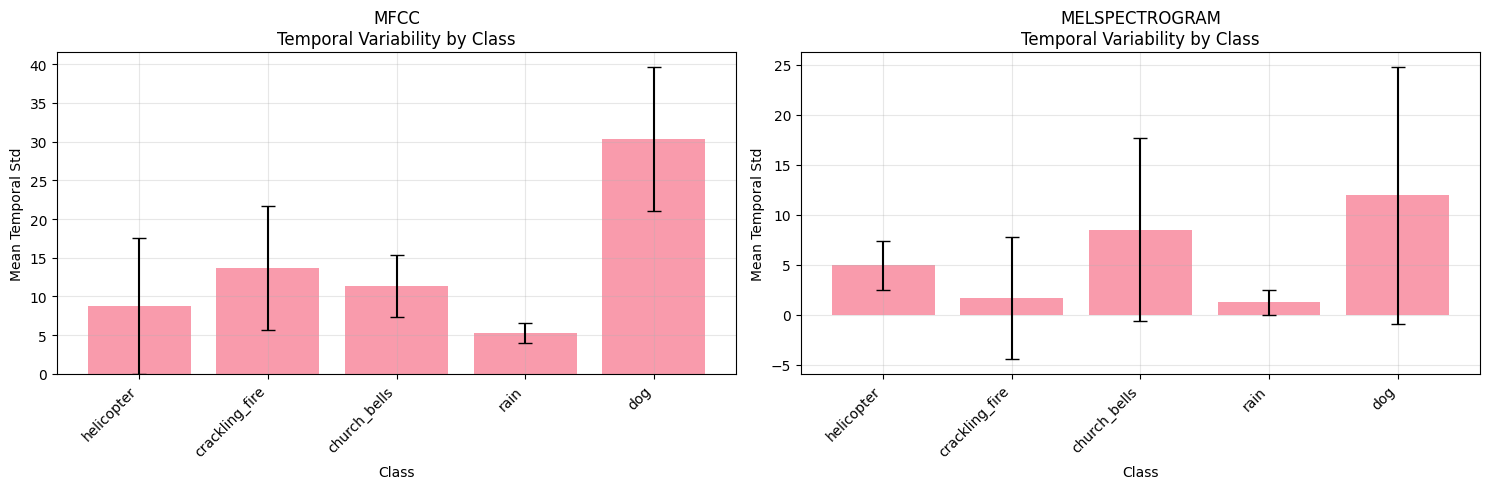


✅ Temporal variability analysis completed


In [5]:
def analyze_temporal_variability(features_list, labels, feature_name):
    """
    Analyze temporal variability of a specific feature across classes.
    """
    class_variabilities = {}
    
    # Group by class
    for class_label in set(labels):
        class_indices = [i for i, label in enumerate(labels) if label == class_label]
        class_features = [features_list[i][feature_name] for i in class_indices]
        
        # Calculate temporal variability (std across time for each feature dimension)
        temporal_stds = []
        for feat_array in class_features:
            if feat_array.ndim > 1:
                # Calculate std across time dimension (last axis)
                temporal_std = np.std(feat_array, axis=-1)
                temporal_stds.append(np.mean(temporal_std))  # Average across feature dimensions
            else:
                temporal_stds.append(0)  # No temporal dimension
        
        class_variabilities[class_label] = {
            'mean_temporal_std': np.mean(temporal_stds),
            'std_temporal_std': np.std(temporal_stds),
            'individual_stds': temporal_stds
        }
    
    return class_variabilities

# Analyze temporal variability for MFCC and Mel spectrogram
print("📊 Analyzing temporal variability across classes...")

temporal_analysis = {}
for feature_name in FOCUS_FEATURES:
    print(f"\n🎯 {feature_name.upper()} Temporal Variability:")
    
    variability = analyze_temporal_variability(features_data, labels, feature_name)
    temporal_analysis[feature_name] = variability
    
    # Display results
    for class_label, stats in variability.items():
        print(f"  {class_label:15s}: μ={stats['mean_temporal_std']:.4f}, σ={stats['std_temporal_std']:.4f}")

# Create visualization of temporal variability
fig, axes = plt.subplots(1, len(FOCUS_FEATURES), figsize=(15, 5))
if len(FOCUS_FEATURES) == 1:
    axes = [axes]

for idx, feature_name in enumerate(FOCUS_FEATURES):
    variability_data = temporal_analysis[feature_name]
    
    classes = list(variability_data.keys())
    means = [variability_data[cls]['mean_temporal_std'] for cls in classes]
    stds = [variability_data[cls]['std_temporal_std'] for cls in classes]
    
    x_pos = np.arange(len(classes))
    axes[idx].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Mean Temporal Std')
    axes[idx].set_title(f'{feature_name.upper()}\nTemporal Variability by Class')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(classes, rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Temporal variability analysis completed")

## Class Separability Analysis

📊 Calculating class separability metrics...

🎯 Frame-wise (No Aggregation):
  📈 Silhouette Score: -0.0947
  📐 Feature Dimensions: 30404
  📊 Separation Ratio: 1.0854
  🎯 Intra-class Distance: 201.6661
  🌐 Inter-class Distance: 218.8967

🎯 Sliding Window (Small):
  📈 Silhouette Score: -0.0916
  📐 Feature Dimensions: 14920
  📊 Separation Ratio: 1.0965
  🎯 Intra-class Distance: 137.9932
  🌐 Inter-class Distance: 151.3137

🎯 Sliding Window (Large):
  📈 Silhouette Score: -0.0843
  📐 Feature Dimensions: 2820
  📊 Separation Ratio: 1.1114
  🎯 Intra-class Distance: 58.0177
  🌐 Inter-class Distance: 64.4792

🎯 Global Aggregation:
  📈 Silhouette Score: 0.0152
  📐 Feature Dimensions: 564
  📊 Separation Ratio: 1.2071
  🎯 Intra-class Distance: 26.6676
  🌐 Inter-class Distance: 32.1900


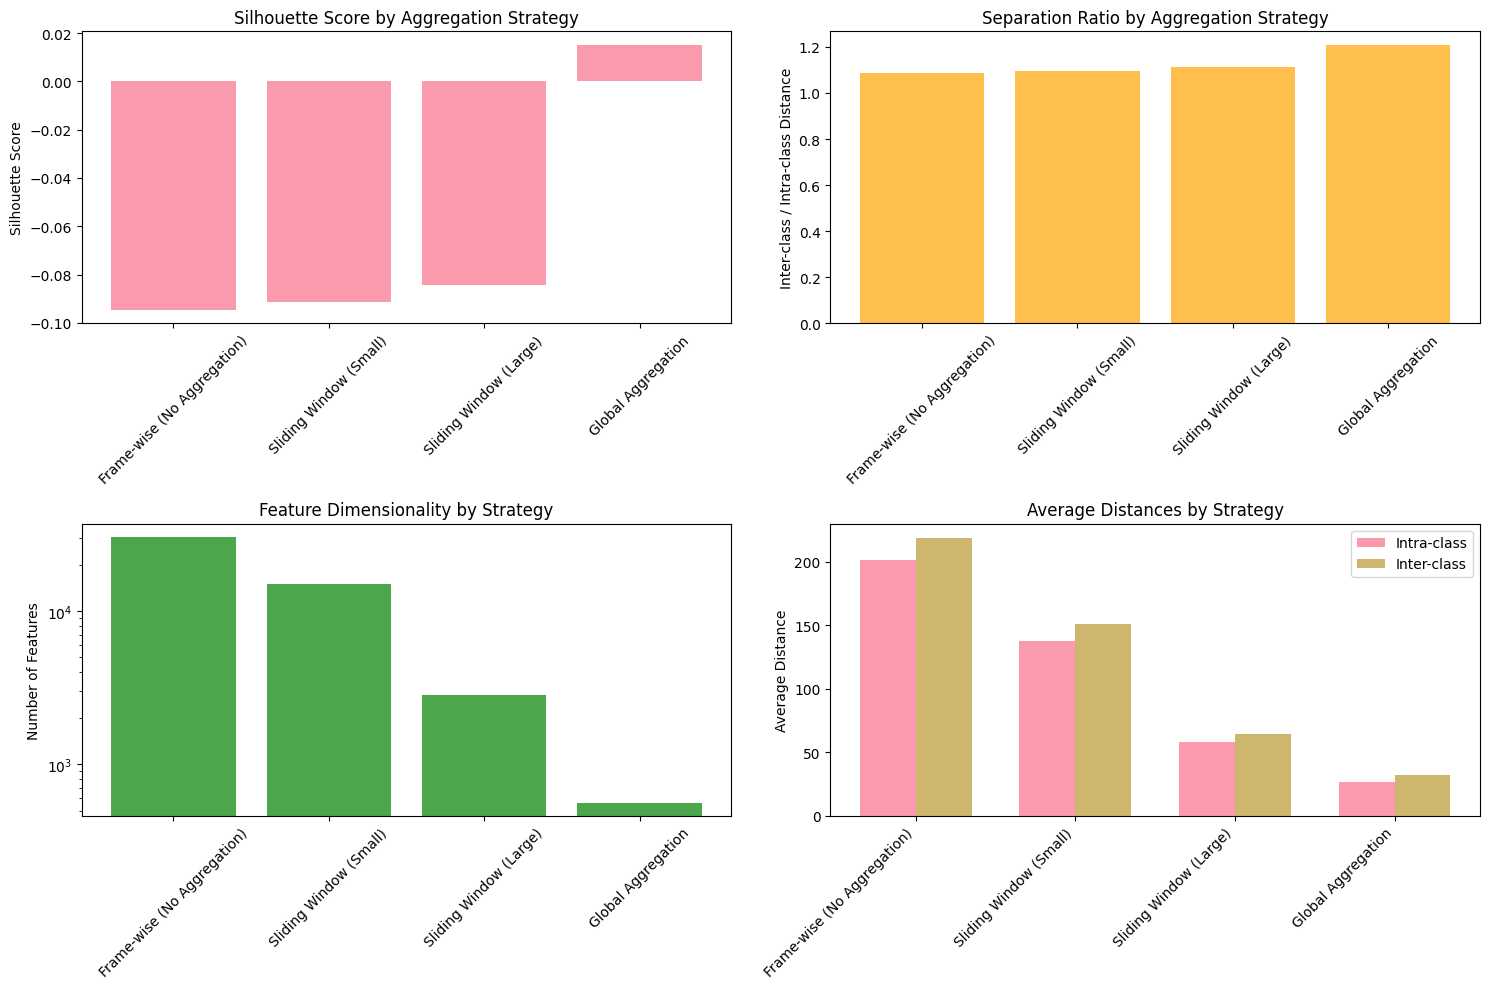


✅ Separability analysis completed


In [6]:
def calculate_separability_metrics(feature_vectors, labels):
    """
    Calculate separability metrics for feature vectors.
    """
    # Ensure we have enough samples
    if len(feature_vectors) < 10:
        return {'silhouette_score': 0, 'error': 'Insufficient samples'}
    
    try:
        # Stack feature vectors
        if isinstance(feature_vectors[0], dict):
            # Convert dict features to vectors
            vector_data = []
            for feat_dict in feature_vectors:
                # Concatenate all feature values
                feat_vector = np.concatenate([v.flatten() for v in feat_dict.values()])
                vector_data.append(feat_vector)
            X = np.array(vector_data)
        else:
            X = np.array(feature_vectors)
        
        # Handle potential infinite or NaN values
        X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Encode labels
        unique_labels = list(set(labels))
        y = np.array([unique_labels.index(label) for label in labels])
        
        # Calculate silhouette score
        if len(unique_labels) > 1:
            silhouette = silhouette_score(X_scaled, y)
        else:
            silhouette = 0
        
        # Calculate intra-class vs inter-class distances
        intra_distances = []
        inter_distances = []
        
        for i, label_i in enumerate(labels):
            for j, label_j in enumerate(labels):
                if i != j:
                    distance = np.linalg.norm(X_scaled[i] - X_scaled[j])
                    if label_i == label_j:
                        intra_distances.append(distance)
                    else:
                        inter_distances.append(distance)
        
        avg_intra = np.mean(intra_distances) if intra_distances else 0
        avg_inter = np.mean(inter_distances) if inter_distances else 0
        separation_ratio = avg_inter / avg_intra if avg_intra > 0 else 0
        
        return {
            'silhouette_score': silhouette,
            'avg_intra_distance': avg_intra,
            'avg_inter_distance': avg_inter,
            'separation_ratio': separation_ratio,
            'n_features': X.shape[1],
            'n_samples': X.shape[0]
        }
        
    except Exception as e:
        return {'error': str(e), 'silhouette_score': 0}

# Calculate separability for each aggregation strategy
print("📊 Calculating class separability metrics...")

separability_results = {}
for strategy_key, strategy_data in aggregated_results.items():
    print(f"\n🎯 {strategy_data['info']['name']}:")
    
    metrics = calculate_separability_metrics(
        strategy_data['data'], 
        strategy_data['labels']
    )
    
    separability_results[strategy_key] = metrics
    
    if 'error' in metrics:
        print(f"  ⚠️  Error: {metrics['error']}")
    else:
        print(f"  📈 Silhouette Score: {metrics['silhouette_score']:.4f}")
        print(f"  📐 Feature Dimensions: {metrics['n_features']}")
        print(f"  📊 Separation Ratio: {metrics['separation_ratio']:.4f}")
        print(f"  🎯 Intra-class Distance: {metrics['avg_intra_distance']:.4f}")
        print(f"  🌐 Inter-class Distance: {metrics['avg_inter_distance']:.4f}")

# Create comparison visualization
valid_strategies = {k: v for k, v in separability_results.items() if 'error' not in v}

if valid_strategies:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    strategy_names = list(valid_strategies.keys())
    strategy_labels = [aggregated_results[k]['info']['name'] for k in strategy_names]
    
    # Silhouette scores
    silhouette_scores = [valid_strategies[k]['silhouette_score'] for k in strategy_names]
    axes[0, 0].bar(strategy_labels, silhouette_scores, alpha=0.7)
    axes[0, 0].set_title('Silhouette Score by Aggregation Strategy')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Separation ratios
    separation_ratios = [valid_strategies[k]['separation_ratio'] for k in strategy_names]
    axes[0, 1].bar(strategy_labels, separation_ratios, alpha=0.7, color='orange')
    axes[0, 1].set_title('Separation Ratio by Aggregation Strategy')
    axes[0, 1].set_ylabel('Inter-class / Intra-class Distance')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Feature dimensions
    n_features = [valid_strategies[k]['n_features'] for k in strategy_names]
    axes[1, 0].bar(strategy_labels, n_features, alpha=0.7, color='green')
    axes[1, 0].set_title('Feature Dimensionality by Strategy')
    axes[1, 0].set_ylabel('Number of Features')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_yscale('log')
    
    # Distance comparison
    intra_distances = [valid_strategies[k]['avg_intra_distance'] for k in strategy_names]
    inter_distances = [valid_strategies[k]['avg_inter_distance'] for k in strategy_names]
    
    x_pos = np.arange(len(strategy_names))
    width = 0.35
    
    axes[1, 1].bar(x_pos - width/2, intra_distances, width, label='Intra-class', alpha=0.7)
    axes[1, 1].bar(x_pos + width/2, inter_distances, width, label='Inter-class', alpha=0.7)
    axes[1, 1].set_title('Average Distances by Strategy')
    axes[1, 1].set_ylabel('Average Distance')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(strategy_labels, rotation=45, ha='right')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

print("\n✅ Separability analysis completed")

## Time Series Evolution Analysis

📈 Analyzing time series evolution of features...

🎯 MFCC Time Series Evolution:


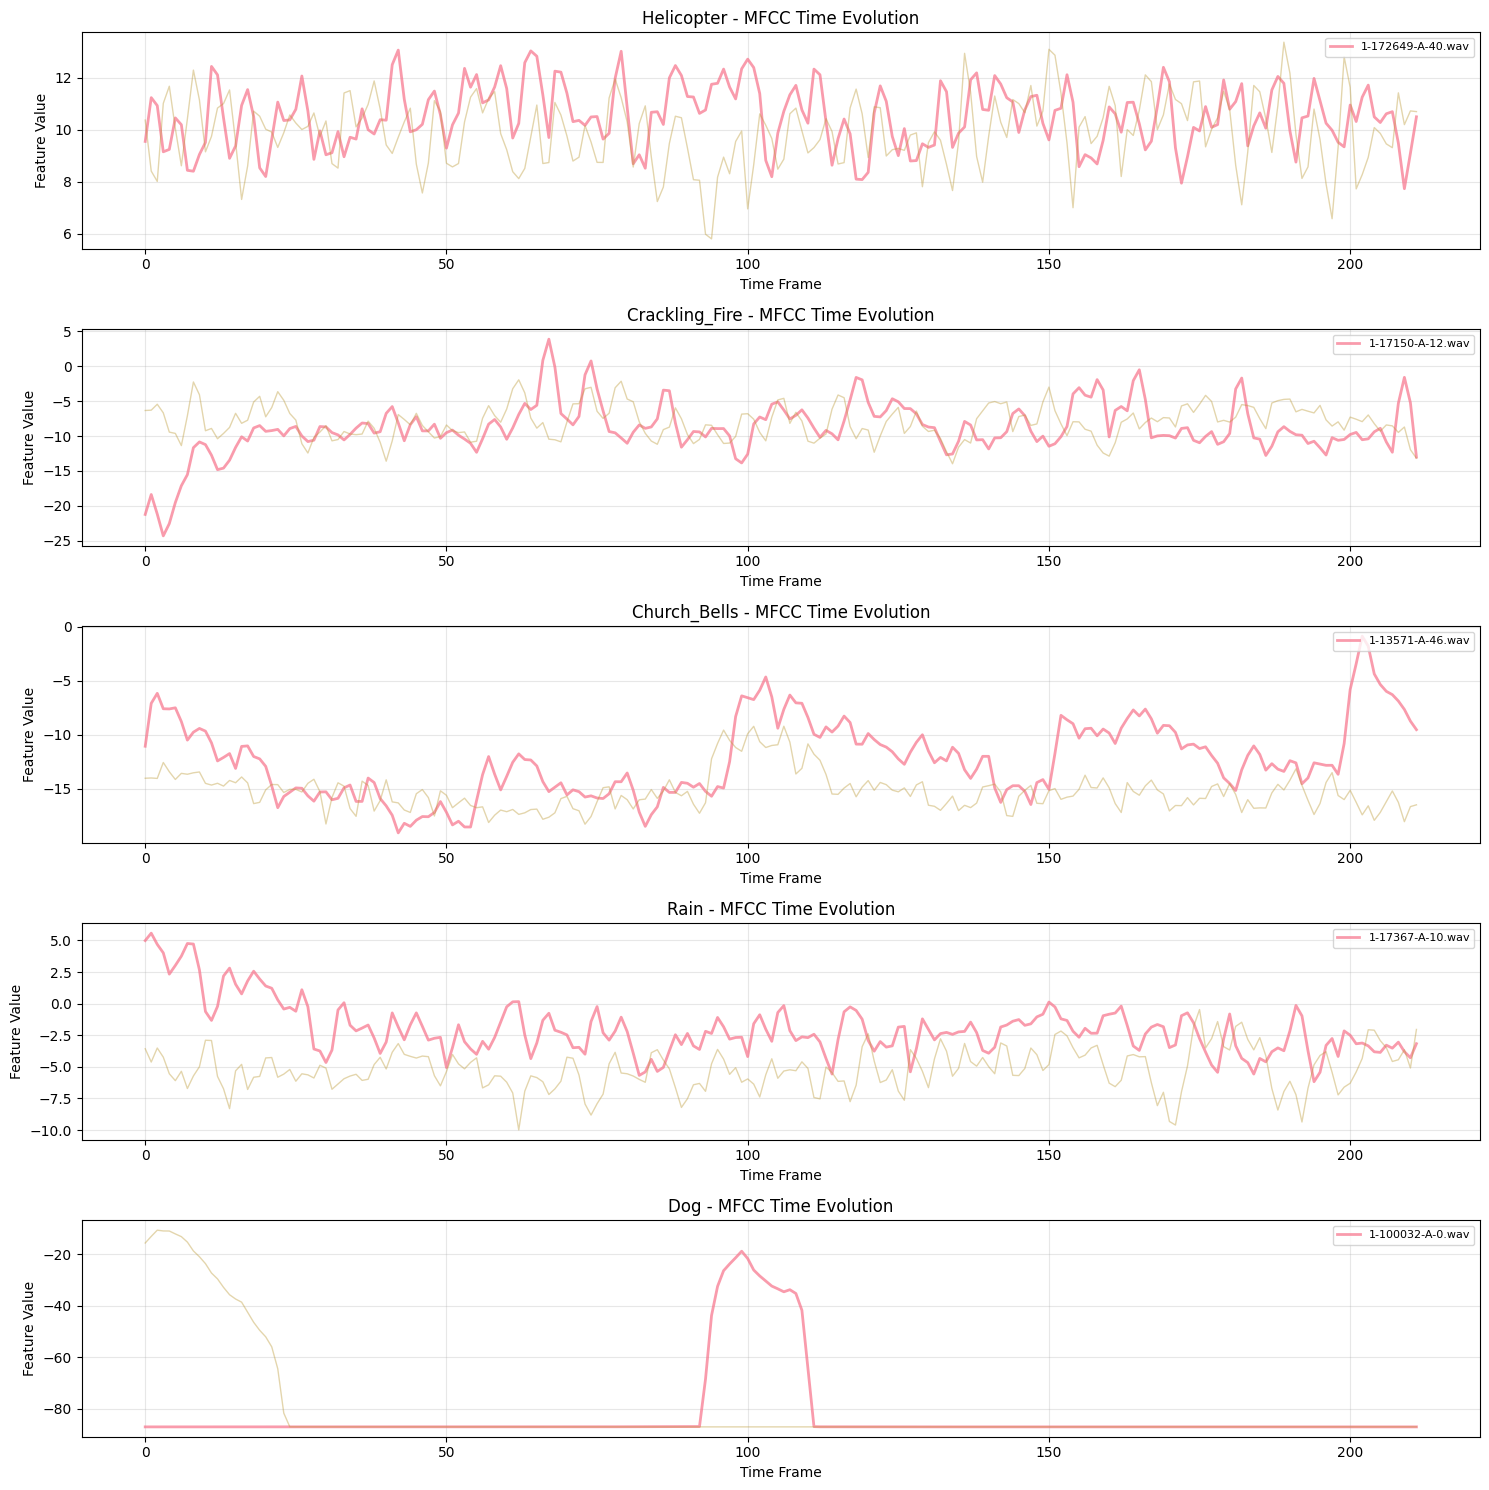


🎯 MELSPECTROGRAM Time Series Evolution:


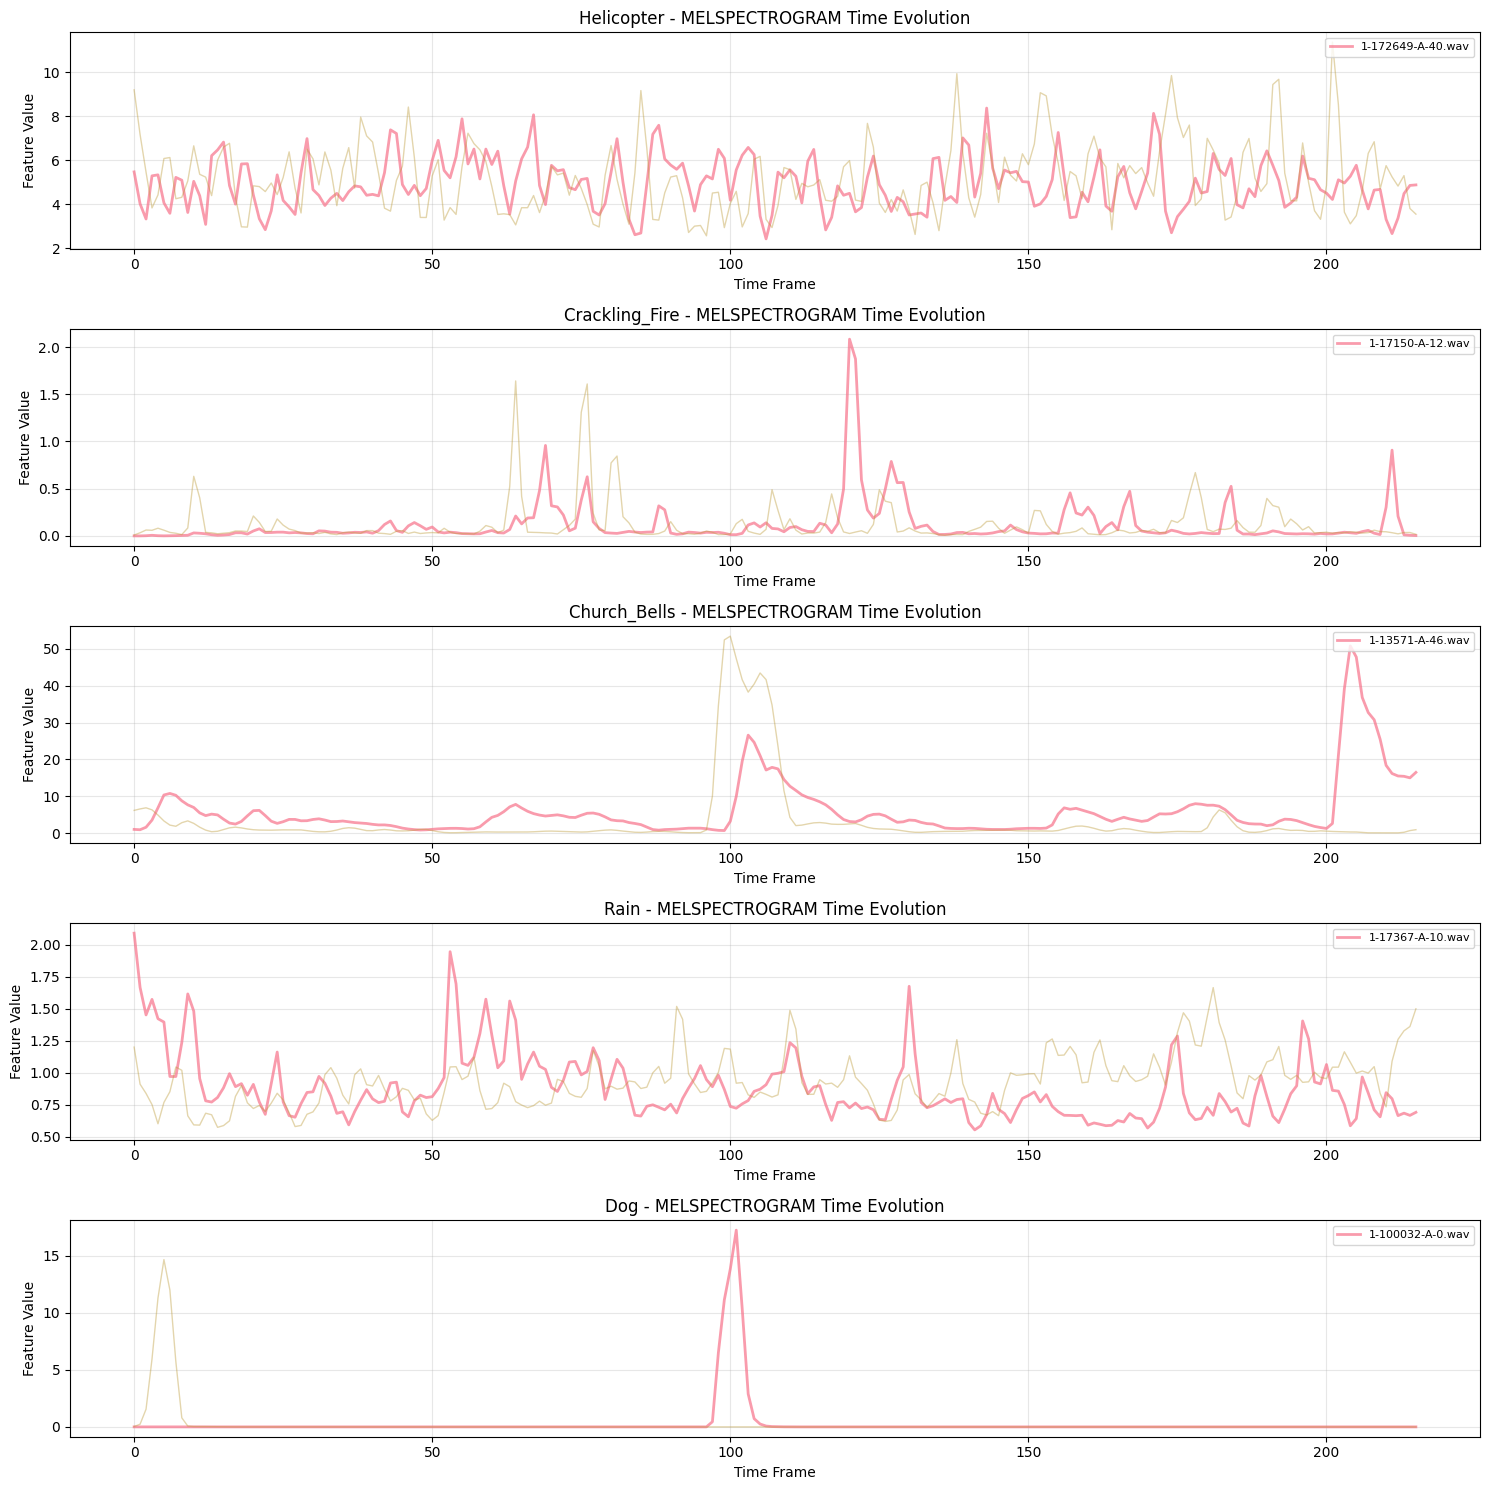

✅ Time series analysis completed


In [7]:
def plot_feature_time_series(features_list, labels, filenames, feature_name, n_examples=3):
    """
    Plot time series evolution of features for representative clips.
    """
    # Select representative examples from each class
    unique_classes = list(set(labels))
    
    fig, axes = plt.subplots(len(unique_classes), 1, figsize=(15, 3*len(unique_classes)))
    if len(unique_classes) == 1:
        axes = [axes]
    
    for class_idx, class_label in enumerate(unique_classes):
        # Get indices for this class
        class_indices = [i for i, label in enumerate(labels) if label == class_label]
        
        # Select up to n_examples from this class
        selected_indices = class_indices[:min(n_examples, len(class_indices))]
        
        for example_idx, data_idx in enumerate(selected_indices):
            feature_data = features_list[data_idx][feature_name]
            
            if feature_data.ndim > 1:
                # For multi-dimensional features, plot the mean across dimensions
                time_series = np.mean(feature_data, axis=0)
            else:
                time_series = feature_data
            
            # Create time axis
            time_axis = np.arange(len(time_series))
            
            # Plot with different alpha and colors for multiple examples
            alpha = 0.7 if example_idx == 0 else 0.4
            label_text = f"{filenames[data_idx]}" if example_idx == 0 else None
            
            axes[class_idx].plot(time_axis, time_series, alpha=alpha, 
                               label=label_text, linewidth=2 if example_idx == 0 else 1)
        
        axes[class_idx].set_title(f'{class_label.title()} - {feature_name.upper()} Time Evolution')
        axes[class_idx].set_xlabel('Time Frame')
        axes[class_idx].set_ylabel('Feature Value')
        axes[class_idx].grid(True, alpha=0.3)
        
        if len(selected_indices) > 0:
            axes[class_idx].legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Plot time series evolution for each focus feature
print("📈 Analyzing time series evolution of features...")

for feature_name in FOCUS_FEATURES:
    print(f"\n🎯 {feature_name.upper()} Time Series Evolution:")
    plot_feature_time_series(features_data, labels, filenames, feature_name, n_examples=2)

print("✅ Time series analysis completed")

## Classification Performance Comparison

🔄 Evaluating classification performance...

🎯 Frame-wise (No Aggregation):
  📈 Train Accuracy: 1.000
  📊 Test Accuracy: 0.917
  📐 Features: 30404

🎯 Sliding Window (Small):
  📈 Train Accuracy: 1.000
  📊 Test Accuracy: 0.933
  📐 Features: 14920

🎯 Sliding Window (Large):
  📈 Train Accuracy: 1.000
  📊 Test Accuracy: 0.917
  📐 Features: 2820

🎯 Global Aggregation:
  📈 Train Accuracy: 1.000
  📊 Test Accuracy: 0.933
  📐 Features: 564


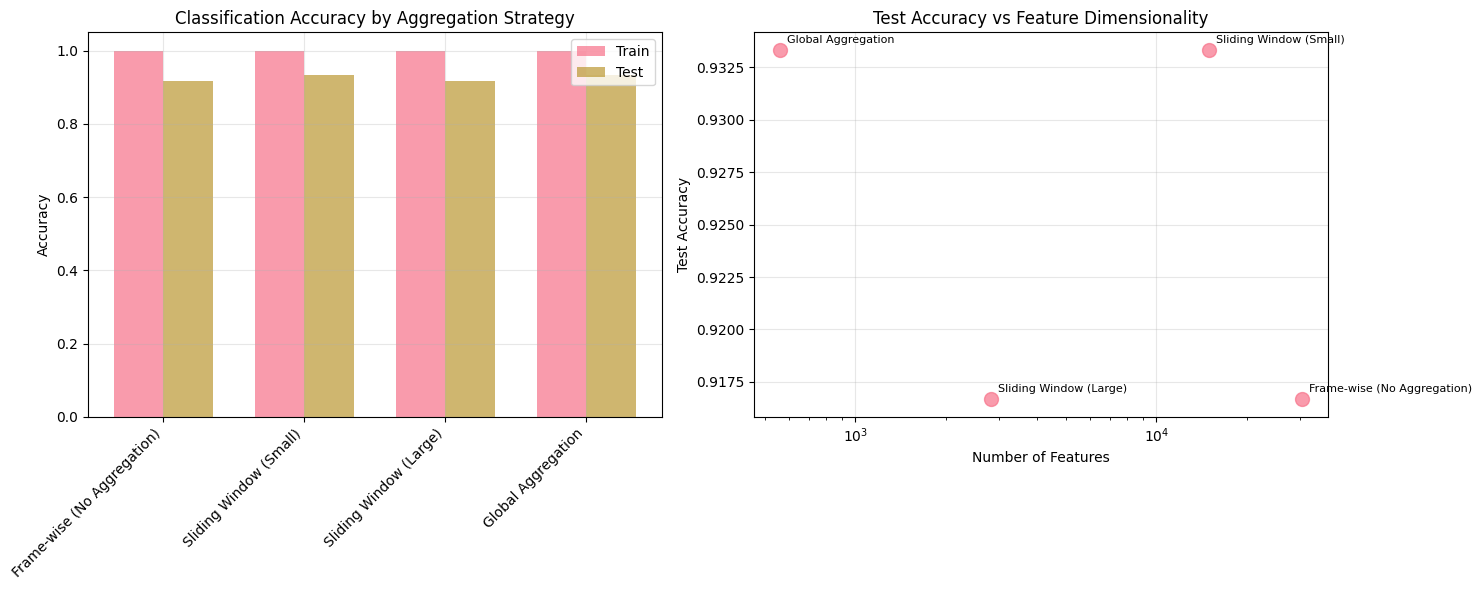


🏆 Best performing strategy: Sliding Window (Small)


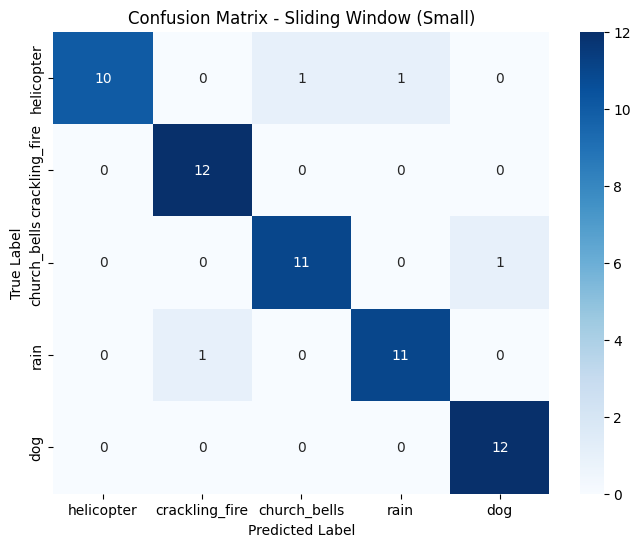


✅ Classification performance analysis completed


In [8]:
def evaluate_classification_performance(feature_vectors, labels, strategy_name):
    """
    Evaluate classification performance using Random Forest.
    """
    try:
        # Convert feature dictionaries to vectors
        if isinstance(feature_vectors[0], dict):
            vector_data = []
            for feat_dict in feature_vectors:
                feat_vector = np.concatenate([v.flatten() for v in feat_dict.values()])
                vector_data.append(feat_vector)
            X = np.array(vector_data)
        else:
            X = np.array(feature_vectors)
        
        # Handle infinite/NaN values
        X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
        
        # Prepare labels
        unique_labels = list(set(labels))
        y = np.array([unique_labels.index(label) for label in labels])
        
        # Split data
        if len(X) < 10:
            return {'error': 'Insufficient samples for train/test split'}
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled, y_train)
        
        # Evaluate
        train_accuracy = rf.score(X_train_scaled, y_train)
        test_accuracy = rf.score(X_test_scaled, y_test)
        
        # Predictions for confusion matrix
        y_pred = rf.predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred)
        
        return {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'confusion_matrix': cm,
            'class_labels': unique_labels,
            'n_features': X.shape[1],
            'model': rf
        }
        
    except Exception as e:
        return {'error': str(e)}

# Evaluate classification performance for each strategy
print("🔄 Evaluating classification performance...")

classification_results = {}
for strategy_key, strategy_data in aggregated_results.items():
    print(f"\n🎯 {strategy_data['info']['name']}:")
    
    results = evaluate_classification_performance(
        strategy_data['data'], 
        strategy_data['labels'],
        strategy_key
    )
    
    classification_results[strategy_key] = results
    
    if 'error' in results:
        print(f"  ⚠️  Error: {results['error']}")
    else:
        print(f"  📈 Train Accuracy: {results['train_accuracy']:.3f}")
        print(f"  📊 Test Accuracy: {results['test_accuracy']:.3f}")
        print(f"  📐 Features: {results['n_features']}")

# Create performance comparison visualization
valid_results = {k: v for k, v in classification_results.items() if 'error' not in v}

if valid_results:
    # Performance comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    strategy_names = list(valid_results.keys())
    strategy_labels = [aggregated_results[k]['info']['name'] for k in strategy_names]
    
    train_accs = [valid_results[k]['train_accuracy'] for k in strategy_names]
    test_accs = [valid_results[k]['test_accuracy'] for k in strategy_names]
    
    x_pos = np.arange(len(strategy_names))
    width = 0.35
    
    axes[0].bar(x_pos - width/2, train_accs, width, label='Train', alpha=0.7)
    axes[0].bar(x_pos + width/2, test_accs, width, label='Test', alpha=0.7)
    axes[0].set_title('Classification Accuracy by Aggregation Strategy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(strategy_labels, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Feature dimensionality vs performance
    n_features = [valid_results[k]['n_features'] for k in strategy_names]
    axes[1].scatter(n_features, test_accs, s=100, alpha=0.7)
    
    for i, label in enumerate(strategy_labels):
        axes[1].annotate(label, (n_features[i], test_accs[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Test Accuracy')
    axes[1].set_title('Test Accuracy vs Feature Dimensionality')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display confusion matrices for best performing strategy
    best_strategy = max(valid_results.keys(), 
                       key=lambda k: valid_results[k]['test_accuracy'])
    
    print(f"\n🏆 Best performing strategy: {aggregated_results[best_strategy]['info']['name']}")
    
    cm = valid_results[best_strategy]['confusion_matrix']
    class_labels = valid_results[best_strategy]['class_labels']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {aggregated_results[best_strategy]["info"]["name"]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("\n✅ Classification performance analysis completed")

## Summary and Insights

In [9]:
# Create comprehensive summary
print("📋 TEMPORAL AGGREGATION ANALYSIS SUMMARY")
print("=" * 50)

# Summary table
summary_data = []

for strategy_key in aggregation_strategies.keys():
    strategy_info = aggregated_results[strategy_key]['info']
    
    # Get metrics
    sep_metrics = separability_results.get(strategy_key, {})
    clf_metrics = classification_results.get(strategy_key, {})
    
    row = {
        'Strategy': strategy_info['name'],
        'Description': strategy_info['description'],
        'Features': clf_metrics.get('n_features', 'N/A'),
        'Silhouette': f"{sep_metrics.get('silhouette_score', 0):.3f}",
        'Separation': f"{sep_metrics.get('separation_ratio', 0):.3f}",
        'Test Accuracy': f"{clf_metrics.get('test_accuracy', 0):.3f}" if 'test_accuracy' in clf_metrics else 'N/A'
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n📊 STRATEGY COMPARISON:")
print(summary_df.to_string(index=False))

# Key insights
print("\n\n🔍 KEY INSIGHTS:")
print("-" * 20)

# Find best strategies
valid_sep = {k: v for k, v in separability_results.items() if 'error' not in v}
valid_clf = {k: v for k, v in classification_results.items() if 'error' not in v}

if valid_sep:
    best_silhouette = max(valid_sep.keys(), key=lambda k: valid_sep[k]['silhouette_score'])
    best_separation = max(valid_sep.keys(), key=lambda k: valid_sep[k]['separation_ratio'])
    
    print(f"🏆 Best Silhouette Score: {aggregated_results[best_silhouette]['info']['name']}")
    print(f"   Score: {valid_sep[best_silhouette]['silhouette_score']:.4f}")
    
    print(f"\n🏆 Best Separation Ratio: {aggregated_results[best_separation]['info']['name']}")
    print(f"   Ratio: {valid_sep[best_separation]['separation_ratio']:.4f}")

if valid_clf:
    best_accuracy = max(valid_clf.keys(), key=lambda k: valid_clf[k]['test_accuracy'])
    print(f"\n🏆 Best Classification Accuracy: {aggregated_results[best_accuracy]['info']['name']}")
    print(f"   Accuracy: {valid_clf[best_accuracy]['test_accuracy']:.4f}")

# Temporal variability insights
print("\n\n📊 TEMPORAL VARIABILITY INSIGHTS:")
print("-" * 35)

for feature_name, variability_data in temporal_analysis.items():
    class_variabilities = [stats['mean_temporal_std'] for stats in variability_data.values()]
    most_variable_class = max(variability_data.keys(), 
                             key=lambda k: variability_data[k]['mean_temporal_std'])
    least_variable_class = min(variability_data.keys(), 
                              key=lambda k: variability_data[k]['mean_temporal_std'])
    
    print(f"\n{feature_name.upper()}:")
    print(f"  📈 Most temporally variable: {most_variable_class} "
          f"({variability_data[most_variable_class]['mean_temporal_std']:.4f})")
    print(f"  📉 Least temporally variable: {least_variable_class} "
          f"({variability_data[least_variable_class]['mean_temporal_std']:.4f})")
    print(f"  📊 Overall variability range: {np.std(class_variabilities):.4f}")

# Recommendations
print("\n\n💡 RECOMMENDATIONS:")
print("-" * 20)

print("1. **For Lightweight Models:**")
if valid_clf:
    # Find strategy with good accuracy but fewer features
    accuracy_threshold = 0.7
    lightweight_candidates = {
        k: v for k, v in valid_clf.items() 
        if v['test_accuracy'] >= accuracy_threshold
    }
    
    if lightweight_candidates:
        best_lightweight = min(lightweight_candidates.keys(), 
                              key=lambda k: lightweight_candidates[k]['n_features'])
        print(f"   Recommended: {aggregated_results[best_lightweight]['info']['name']}")
        print(f"   Features: {lightweight_candidates[best_lightweight]['n_features']}")
        print(f"   Accuracy: {lightweight_candidates[best_lightweight]['test_accuracy']:.3f}")
    else:
        print("   Consider global aggregation for significant dimensionality reduction")

print("\n2. **For Maximum Accuracy:**")
if valid_clf:
    best_acc_strategy = max(valid_clf.keys(), key=lambda k: valid_clf[k]['test_accuracy'])
    print(f"   Recommended: {aggregated_results[best_acc_strategy]['info']['name']}")
    print(f"   Accuracy: {valid_clf[best_acc_strategy]['test_accuracy']:.3f}")

print("\n3. **For Real-time Applications:**")
print("   Consider sliding window with small windows for balance between")
print("   temporal resolution and computational efficiency.")

print("\n4. **Class-specific Considerations:**")
for feature_name, variability_data in temporal_analysis.items():
    high_var_classes = [k for k, v in variability_data.items() 
                       if v['mean_temporal_std'] > np.mean([s['mean_temporal_std'] 
                                                           for s in variability_data.values()])]
    if high_var_classes:
        print(f"   {feature_name.upper()}: Classes {high_var_classes} benefit from higher temporal resolution")

print("\n\n✅ Analysis completed successfully!")
print("\n📝 Next steps: See the aggregation improvements report for detailed recommendations.")

📋 TEMPORAL AGGREGATION ANALYSIS SUMMARY

📊 STRATEGY COMPARISON:
                   Strategy                                Description  Features Silhouette Separation Test Accuracy
Frame-wise (No Aggregation)          Preserve full temporal resolution     30404     -0.095      1.085         0.917
     Sliding Window (Small)       Window size: 5 frames, hop: 2 frames     14920     -0.092      1.097         0.933
     Sliding Window (Large)     Window size: 20 frames, hop: 10 frames      2820     -0.084      1.111         0.917
         Global Aggregation Mean, std, skew, kurtosis over entire clip       564      0.015      1.207         0.933


🔍 KEY INSIGHTS:
--------------------
🏆 Best Silhouette Score: Global Aggregation
   Score: 0.0152

🏆 Best Separation Ratio: Global Aggregation
   Ratio: 1.2071

🏆 Best Classification Accuracy: Sliding Window (Small)
   Accuracy: 0.9333


📊 TEMPORAL VARIABILITY INSIGHTS:
-----------------------------------

MFCC:
  📈 Most temporally variable: dog (